In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import scikitplot as skplt

In [2]:
%load_ext watermark
%watermark -v -n -m -p numpy,sklearn,pandas,seaborn

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy  : 1.23.5
sklearn: 1.2.0
pandas : 1.4.3
seaborn: 0.12.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



## Data 

The data was obtained from UCI's Machine Learning Repository. Its a subset of e-commerce shopping history for customers of a company, and contains 12,330 sessions. 84.5% (10,422) were negative class samples that did not end with shopping, and the rest (1908) were positive class samples ending with shopping.


The data and information on the original contributors can be found here:

https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset  
Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018)

In [3]:
# Read the dataset
ecommerce_data = pd.read_csv(r'data\online_shoppers_intention.csv')

In [4]:
ecommerce_data.shape

(12330, 18)

### Problem 

We would like to be able to classify future sessions into clusters of transactions vs non-transactions. Once the model is trained we could apply it to live sessions to predict whether a customer is about the transact or abandon their session and have additional marketing support for that segment.

# Inspect, Visualize and Clean the Data 

## Exploratory Data Analysis (EDA) 

In [5]:
# Looking at a sample dataset
ecommerce_data.sample(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
10302,4,367.000000,5,2256.916667,74,8981.580128,0.002989,0.043302,0.000000,0.0,Dec,2,2,1,8,Returning_Visitor,False,False
6916,0,0.000000,0,0.000000,8,316.133333,0.000000,0.050000,0.000000,0.0,June,2,2,3,13,Returning_Visitor,False,False
1555,0,0.000000,0,0.000000,24,1762.250000,0.008333,0.016667,0.000000,0.0,Mar,2,2,2,1,Returning_Visitor,False,False
5065,0,0.000000,0,0.000000,2,247.000000,0.000000,0.100000,0.000000,0.0,May,1,1,1,1,Returning_Visitor,False,False
5012,0,0.000000,0,0.000000,23,684.500000,0.021739,0.044928,0.000000,0.8,May,2,2,2,6,Returning_Visitor,False,False
5635,4,96.600000,0,0.000000,15,276.733333,0.010526,0.021053,69.462395,0.0,Oct,2,2,1,4,Returning_Visitor,True,True
10580,0,0.000000,0,0.000000,3,0.000000,0.200000,0.200000,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,False,False
8015,1,6.500000,0,0.000000,10,511.250000,0.000000,0.007407,7.848539,0.0,Dec,2,5,3,8,New_Visitor,True,True
7,1,0.000000,0,0.000000,0,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
11371,10,198.243056,3,276.250000,151,4344.919986,0.002532,0.011966,0.000000,0.0,Dec,4,2,4,2,Returning_Visitor,False,False


According to the authors of the paper, the first six columns are aggregates for different types of pages visited by the user in the session and total time spent in the categories. The Bounce Rate and Exit Rate features are averages for all visitors rather during the time frame.

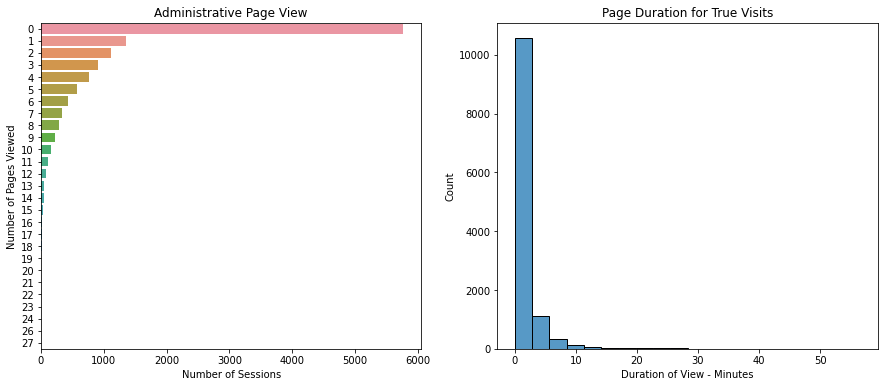

In [6]:
figs, axs = plt.subplots(ncols=2,
                        figsize=(15,6))

g1 = sns.barplot(data=ecommerce_data['Administrative'].value_counts().to_frame().reset_index(),
            x='Administrative',
            y='index',
            orient='h',
            ax=axs[0]).set(title='Administrative Page View', xlabel='Number of Sessions', ylabel='Number of Pages Viewed')

g2 = sns.histplot(data=ecommerce_data[ecommerce_data['Administrative'] != 0],
             x=ecommerce_data['Administrative_Duration']/60,
             bins=20,
           ax=axs[1]).set(title='Page Duration for True Visits', xlabel='Duration of View - Minutes', ylabel='Count')

Most users visit do not visit the administrative page, of those that do they don't spend a lot of time there

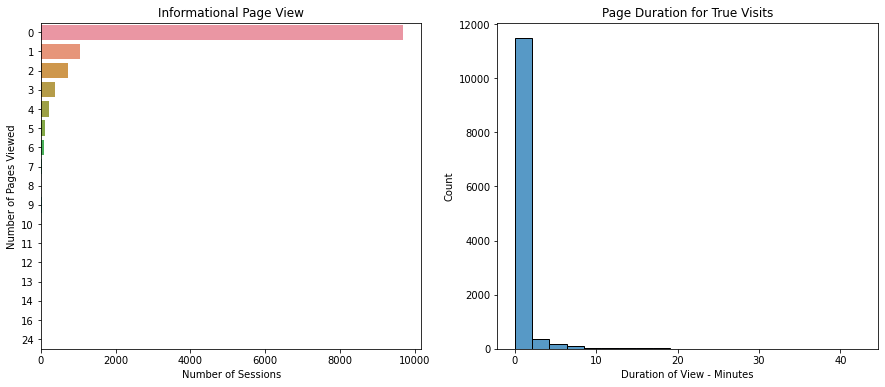

In [7]:
figs, axs = plt.subplots(ncols=2,
                        figsize=(15,6))

g1 = sns.barplot(data=ecommerce_data['Informational'].value_counts().to_frame().reset_index(),
            x='Informational',
            y='index',
            orient='h',
            ax=axs[0]).set(title='Informational Page View', xlabel='Number of Sessions', ylabel='Number of Pages Viewed')

g2 = sns.histplot(data=ecommerce_data[ecommerce_data['Informational'] != 0],
             x=ecommerce_data['Informational_Duration']/60,
             bins=20,
           ax=axs[1]).set(title='Page Duration for True Visits', xlabel='Duration of View - Minutes', ylabel='Count')

Similar story for the informational pages too

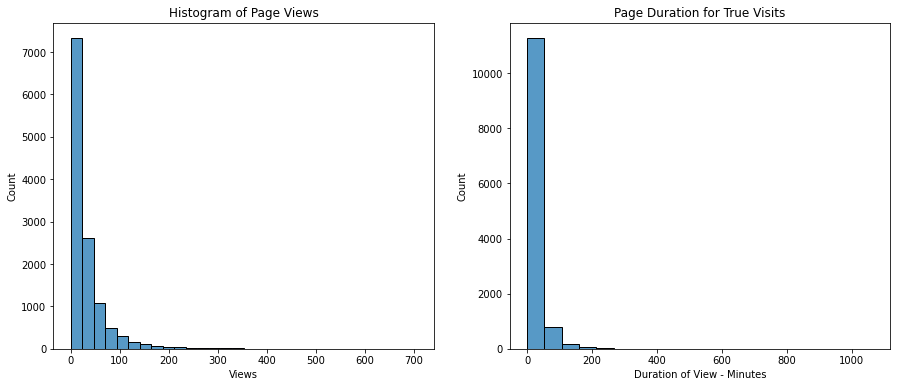

In [8]:
figs, axs = plt.subplots(ncols=2,
                        figsize=(15,6))

g1 = sns.histplot(data=ecommerce_data,
             x='ProductRelated',
             bins=30,
             ax=axs[0]).set(title='Histogram of Page Views', xlabel='Views', ylabel='Count')

g2 = sns.histplot(data=ecommerce_data[ecommerce_data['ProductRelated'] != 0],
                x=ecommerce_data['ProductRelated_Duration']/60,
                bins=20,
                ax=axs[1]).set(title='Page Duration for True Visits', xlabel='Duration of View - Minutes', ylabel='Count')

The product related pages have a lot more views as expected of an e-commerce company. We also see some potential outliers, where the session states that individuals viewed more than 700 pages during a session for over 1000 minutes. This could most likely be a crawling bot.

Before modeling we first attempt to re-categorize the columns do we can perform OHC

In [9]:
categorical = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
boolean_categorical = ['Weekend', 'ReturningVisitor']
numerical = ['Administrative', 'Administrative_Duration', 'Informational',
               'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
               'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [11]:
# We remap the visitor column to a returning visitor boolean
ecommerce_data['ReturningVisitor'] = ecommerce_data['VisitorType']\
                                    .replace({'Returning_Visitor':1, 'New_Visitor':0, 'Other':0})
ecommerce_data.drop('VisitorType', axis=1, inplace=True)

In [12]:
# We also remap weekends 
ecommerce_data['Weekend'] = ecommerce_data['Weekend'].replace({True:1, False:0})

<AxesSubplot: >

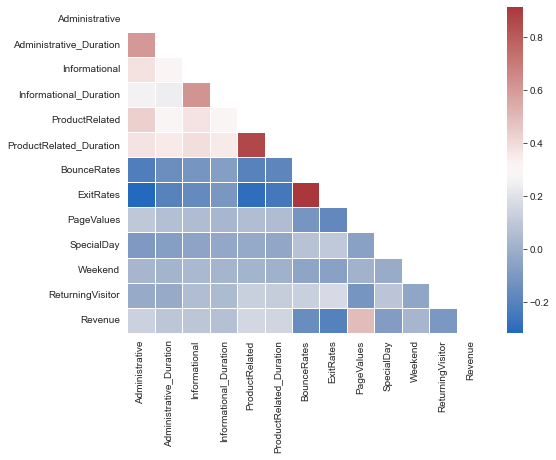

In [13]:
# We can now plot a correlation matrix using numeric and boolean featues
corr = ecommerce_data[[*numerical, *boolean_categorical, 'Revenue']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8,6))
sns.set_style('white')
sns.heatmap(corr, 
            mask=mask, 
            linewidths=1,
           cmap="vlag")

## Clean Data

In [14]:
# Remove sessions that were on for more than 4 hours
ecommerce_data = ecommerce_data[ecommerce_data['ProductRelated_Duration'] < 14400]

# Remove sessions that had more than 400 product views
ecommerce_data = ecommerce_data[ecommerce_data['ProductRelated'] < 400]

# Building and training models

## PCA to visualize clusters

In [15]:
# Create the PCA model
pca = make_pipeline(StandardScaler().set_output(transform="pandas"), 
                    PCA(n_components=.9))

In [16]:
# Fit the model and then transform the data
pca.fit(ecommerce_data[numerical])
X = pca.transform(ecommerce_data[numerical])

In [17]:
# Variance for the components
print(pca.named_steps['pca'].explained_variance_ratio_.cumsum())
print(np.sum(pca.named_steps['pca'].explained_variance_ratio_))

[0.33414795 0.49636035 0.6089888  0.71455625 0.81144831 0.90437566]
0.9043756639853244


<AxesSubplot: title={'center': 'PCA Component Explained Variances'}, xlabel='First n principal components', ylabel='Explained variance ratio of first n components'>

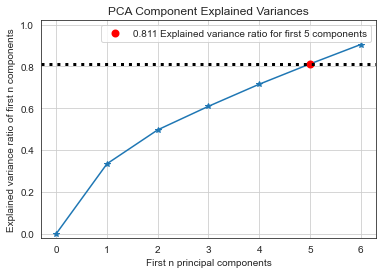

In [18]:
skplt.decomposition.plot_pca_component_variance(pca.named_steps['pca'])

<AxesSubplot: title={'center': 'PCA 2-D Projection'}, xlabel='First Principal Component', ylabel='Second Principal Component'>

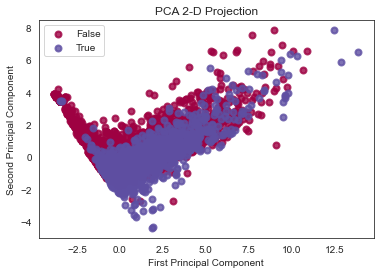

In [19]:
skplt.decomposition.plot_pca_2d_projection(pca, 
                                           ecommerce_data[numerical],
                                           ecommerce_data['Revenue'])

We do not see a clear separation in between sessions with and without transactions for only a 2D projection

In [20]:
# Create another dataset using just the PCA components rather than the numeric ones
# We can compare their performance down the line
ecommerce_data_pca = ecommerce_data.drop(numerical, axis=1)
ecommerce_data_pca[[f'component_{x}' for x in range(X.shape[1])]] = X

## Model

### OHC and Spliting Dataset

In [21]:
# OHC both datasets
ecommerce_ohc = pd.get_dummies(ecommerce_data[categorical])\
                .merge(ecommerce_data[[x for x in ecommerce_data.columns if x not in categorical]],
                       left_index=True, 
                       right_index=True)
ecommerce_pca_ohc = pd.get_dummies(ecommerce_data_pca[categorical])\
                .merge(ecommerce_data_pca[[x for x in ecommerce_data_pca.columns if x not in categorical]],
                       left_index=True, 
                       right_index=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(ecommerce_ohc.drop('Revenue', axis=1), 
                                                    ecommerce_ohc['Revenue'], 
                                                    test_size= 0.25,
                                                    stratify=ecommerce_ohc['Revenue'],
                                                    random_state=42)

### Model

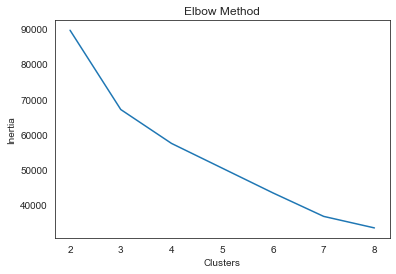

In [23]:
# We can look at the recommended clusters before we actually use the known two clusters
inertia = []
n_clusters = [2, 3, 4, 6, 7, 8]
for i in n_clusters:
    kmeans = KMeans(n_clusters = i, 
                    n_init = 'auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_) 
plt.plot(n_clusters, inertia)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

The elbow method would suggest either 3 clusters or maybe even 7, since we have double clusters. We could try an advanced different method such as Silhouette analysis to validate this.

In [24]:
kmeans = KMeans(n_clusters=2, 
                random_state=42, 
                n_init="auto")
kmeans.fit(X_train)

KMeans(n_clusters=2, n_init='auto', random_state=42)

In [25]:
def label_permute_compare(y_actual, y_pred, n=2):
    """
    Args:
        y_actual -> pd.Series with categories as text
        y_pred -> np.array with predictions
        n -> Number of permutations in y_pred 
    Returns: 
        Predicted labels, accuracy score
    """
    all_scores = []
    actual_labels = y_actual.unique().tolist()
    
    # Generate permutations to check against
    for perm in itertools.permutations(tuple(range(n)), n):
        remap_dict = dict(zip(actual_labels, perm))
        # Change the values in the prediction
        y_actual_coded = y_actual.replace(remap_dict)
        acc = accuracy_score(y_actual_coded, y_pred)           
        all_scores.append([perm, acc])
    
    best_score = sorted(all_scores, key=lambda x:x[1])[-1]
    
    return best_score, actual_labels

In [26]:
# We pass the labels into a function to predict the labels for the clusters
label_predictions = label_permute_compare(y_train, kmeans.labels_)

# Print the results
print(f'Labels are -> {label_predictions[0][0]} for {label_predictions[1]}\
\n Accuracy -> {label_predictions[0][1]}')

Labels are -> (0, 1) for [False, True]
 Accuracy -> 0.8078257099501409


In [27]:
label_category_mapping = dict(zip(label_predictions[0][0], label_predictions[1]))
label_category_mapping

{0: False, 1: True}

In [28]:
# Predict on the unseen testing dataset
y_predictions = kmeans.predict(X_test)

In [29]:
# We pass the labels into a function to predict the labels for the clusters
label_predictions = label_permute_compare(y_test, y_predictions)

# Print the results
print(f'Labels are -> {label_predictions[0][0]} for {label_predictions[1]}\
\n Accuracy -> {label_predictions[0][1]}')

Labels are -> (0, 1) for [False, True]
 Accuracy -> 0.7958387516254877


The labels still remain 0 -> False and 1 -> True, the accuracy dropped by a fraction. We now plot the confusion matrix

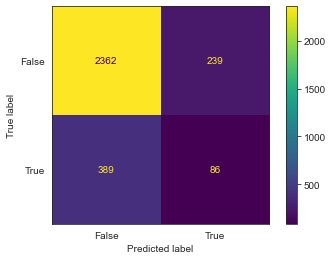

In [30]:
cf_m = ConfusionMatrixDisplay(confusion_matrix(y_test, 
                                               y_predictions,
                                               labels=label_predictions[1]),
                                               display_labels=label_predictions[1])
cf_m.plot()

Recreating the model with the PCA data actually caused its accuracy to drop from 0.80 to 0.73. Given that the features we decomposed were aggregates themselves, it might be better to work on reducing the categorical data that we have to OHC rather than use PCA to reduce the number of dimensions in this case.

#  Compare with supervised learning 

## Supervised Model

We will now predict the categories using a supervised model (KNN)

In [31]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [32]:
knn_predictions = knn.predict(X_test)

In [33]:
accuracy_score(y_test, knn_predictions)  

0.8585825747724317

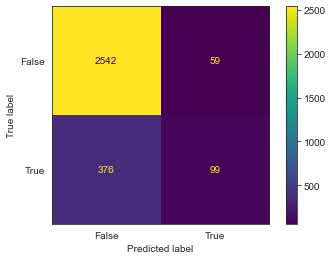

In [34]:
cf_m_sup = ConfusionMatrixDisplay(confusion_matrix(y_test, 
                                                   knn_predictions,
                                                   labels=label_predictions[1]),
                                                   display_labels=label_predictions[1])
cf_m_sup.plot()

The supervised model did a lot better job

# References


<br>Dataset https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#</br>
<br>Sklearn Library https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html/br>